In [232]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [233]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [234]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [235]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [236]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [237]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [238]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [239]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [240]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date

'2017-08-23'

In [241]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [242]:
measurement_columns_df = pd.DataFrame(inspector.get_columns('measurement'))
measurement_columns_df

,name,type,nullable,default,primary_key
0,id,INTEGER,False,None,1
1,station,TEXT,True,None,0
2,date,TEXT,True,None,0
3,prcp,FLOAT,True,None,0
4,tobs,FLOAT,True,None,0


In [243]:
station_columns_df = pd.DataFrame(inspector.get_columns('station'))
station_columns_df

,name,type,nullable,default,primary_key
0,id,INTEGER,False,None,1
1,station,TEXT,True,None,0
2,name,TEXT,True,None,0
3,latitude,FLOAT,True,None,0
4,longitude,FLOAT,True,None,0
5,elevation,FLOAT,True,None,0


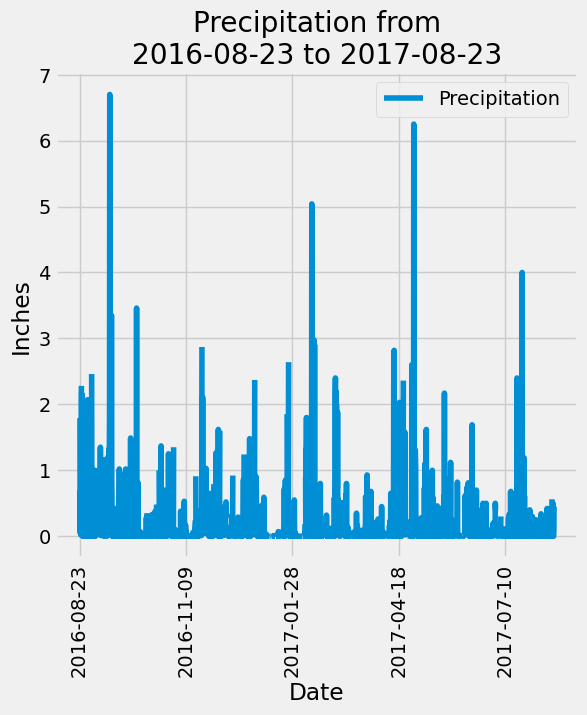

In [244]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_format = "%Y-%m-%d"
end_datetime = dt.datetime.strptime(most_recent_date, date_format)

# Calculate the date one year from the last date in data set.
start_datetime = end_datetime - dt.timedelta(days=365)
start_date = start_datetime.strftime(date_format)
end_date = end_datetime.strftime(date_format)

# Perform a query to retrieve the data and precipitation scores
selection = [Measurement.date, Measurement.prcp]
last_year_query = session.query(*selection).\
        filter(Measurement.date>=start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_precipitation_df = pd.DataFrame(last_year_query, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date
last_year_precipitation_df = last_year_precipitation_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
figure1 = last_year_precipitation_df.plot(x='Date', y='Precipitation',
                                              xlabel='Date', ylabel='Inches', figsize=(6,6),
                                              grid=True, title=f'Precipitation from\n{start_date} to {end_date}')

ticklabels = figure1.xaxis.get_ticklabels()
figure1.set_xticklabels(ticklabels, rotation=90);

In [245]:
# Use Pandas to calculate the summary statistics for the precipitation data
last_year_precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [246]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).distinct().count()

9

In [247]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Station.station, func.count(Measurement.station)).\
                    filter(Measurement.station == Station.station).\
                    group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [248]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]
print(f"Most active station: {most_active_station}")
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

Most active station: USC00519281


[(54.0, 85.0, 71.66378066378067)]

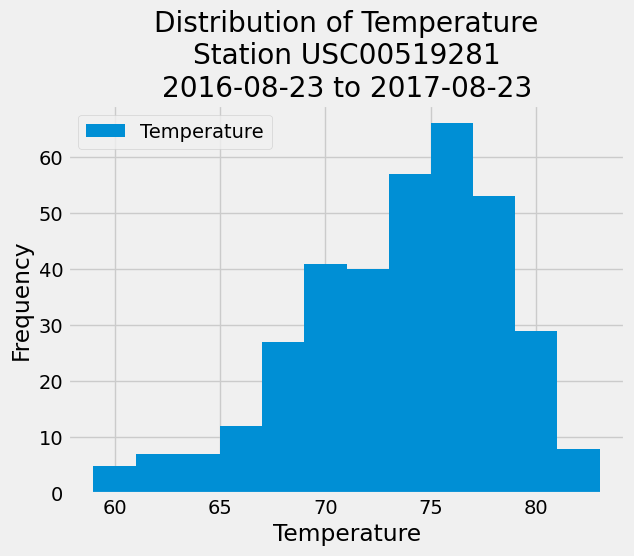

In [249]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
selection = [Measurement.date, Measurement.tobs]
last_year_query = session.query(*selection).\
    filter(Measurement.date>=start_date).\
    filter(Measurement.date<=end_date).\
    filter(Measurement.station == most_active_station).all()

last_year_temp_df = pd.DataFrame(last_year_query, columns=['Date', 'Temperature'])

last_year_temp_df.plot(kind='hist',
                       bins=12,
                       ylabel='Frequency',
                       xlabel='Temperature',
                       title=f'Distribution of Temperature\nStation {most_active_station}\n{start_date} to {end_date}');


# Close Session

In [250]:
# Close Session
session.close()